# Github Actions

In this document we will create a simple Flask app that we will deploy to
Kubernetes on AWS EKS. Use [tiphyspy](https://github.com/opszero/tiphys) as a
template.

The process for deployment is the following:

 - Code. Your code is pushed to Github.
 - Build. If the branch or tag is configured for deployment a Github Actions build is triggered.
 - Build and Push Image. A docker image is built and pushed to AWS Elastic Container Registry.
 - Helm Release. Helm is a package manager defining your application that lives
   within your code. This code defines the environment variables, jobs such as
   migrations, cronjobs, etc. This installs and upgrades your app on Kubernetes.
 - Deploy to EKS. Github deploys to AWS EKS using temporary access given using OIDC.


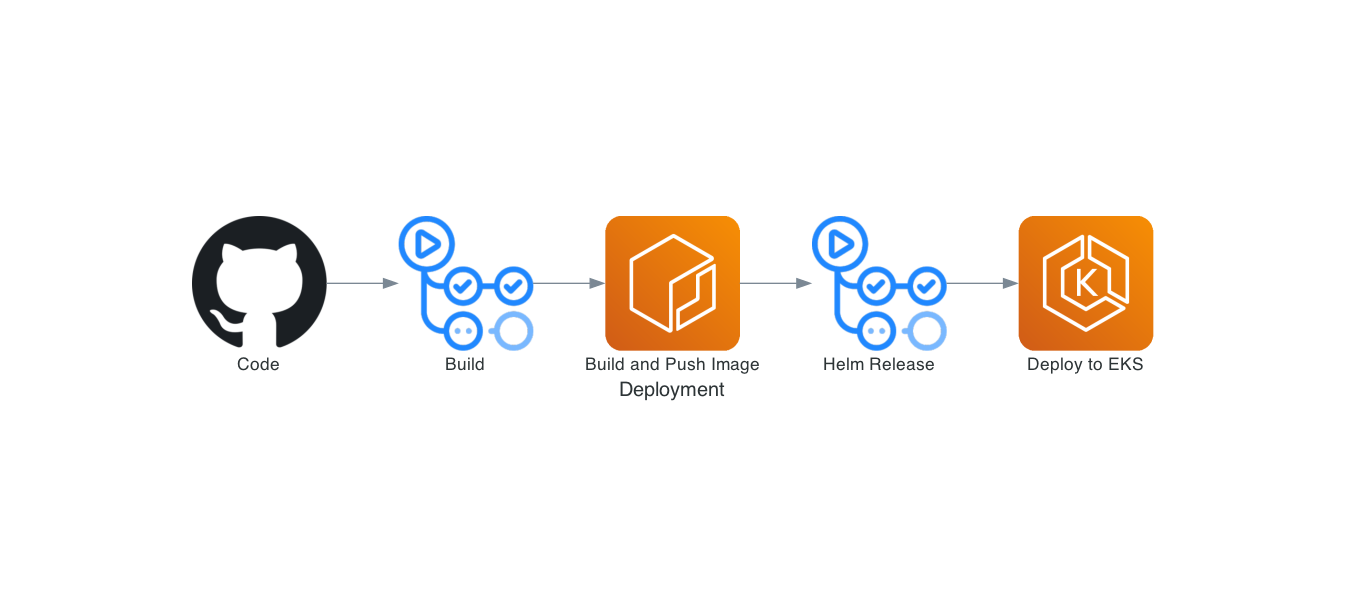

In [5]:
%%capture --no-display

from diagrams import Diagram, Cluster
from diagrams.aws.compute import EC2, ECR, EKS

from diagrams.onprem.vcs import Github
from diagrams.onprem.ci import GithubActions

with Diagram("Deployment", show=False) as diag:
        Github("Code") >> GithubActions("Build") >> ECR("Build and Push Image") >> GithubActions("Helm Release") >> EKS("Deploy to EKS")

diag


### App

Create a simple Flask app in `main.py`

```python
from flask import Flask

app = Flask(__name__)

@app.route("/")
def index():
    return "Hello World with Python Flask!"

app.run(host="0.0.0.0", port=81)
```

### Dockerfile

Create a `Dockerfile`

```dockerfile
FROM python:3.11

WORKDIR /app

RUN pip install Flask

CMD ["python", "main.py"]
```

### Helm Chart

Create the file `deploy.yaml`

```yaml
defaultImage: nginx:latest

redis:
  enabled: false # Enable Redis

apps:
  - name: tiphyspy
    service:
      enabled: true
      type: ClusterIP
      port: 8000
      hosts:
        - host: example.opszero.com
          paths: ["/"]
      command: ["python", "main.py"]
```



### Github Actions

Setup the following `.github/workflows/k8s.yml`


```yaml
name: Deploy

on:
  push:
    branches:
      - main

concurrency:
  group: ${{ github.workflow }}-${{ github.ref }}
  cancel-in-progress: true

jobs:
  deploy:
    name: Test, Build, Deploy
    runs-on: ubuntu-latest
    permissions:
      contents: read
      id-token: write
    env:
      ECR_REGISTRY: ${{ secrets.ECR_REGISTRY }}
      ECR_REPOSITORY: opszero
      IMAGE_TAG: ${{ github.sha }}
    steps:

    - name: Checkout
      uses: actions/checkout@v2

    - name: Configure AWS credentials
      uses: aws-actions/configure-aws-credentials@v1
      with:
        role-to-assume: ${{ secrets.AWS_ROLE_TO_ASSUME }}
        aws-region: us-west-2

    - name: Login to Amazon ECR
      id: login-ecr
      uses: aws-actions/amazon-ecr-login@v1

    - name: Build, tag, and push image to Amazon ECR
      run: |
        docker build -t $ECR_REGISTRY/$ECR_REPOSITORY:$IMAGE_TAG .
        docker push $ECR_REGISTRY/$ECR_REPOSITORY:$IMAGE_TAG
    - name: Release Production
      env:
        CLUSTER_NAME: opszero
      run: |
        aws eks update-kubeconfig --name $CLUSTER_NAME
        helm repo add tiphys https://opszero.github.io/tiphys
        helm repo update
        helm upgrade --install tiphyspy tiphys/tiphys --timeout 10m -f ./deploy.yaml
```